# Task 2: Multi Product with B constrain


In [123]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, multivariate_normal
from scipy.optimize import linear_sum_assignment, linprog
from scipy import optimize

# Environment Setup

# Enviroment

In [124]:

class MultiProductPricingEnvironment:
    """
    Multi-product pricing environment with joint valuation distribution
    """
    def __init__(self, valuation_means, valuation_cov, prices, T, seed=None):
        self.means = np.array(valuation_means)
        self.cov = np.array(valuation_cov)
        self.rng = np.random.default_rng(seed)
        self.prices = np.array(prices)
        # Create multivariate normal distribution
        self.valuation_dist = multivariate_normal(self.means, self.cov)
        
    def simulate_round(self, pricing_decisions):
        """
        pricing_decisions: list of (product_idx, price_idx) tuples or array of price indices
        Returns: rewards, purchases, actual_prices
        """
        # Sample correlated valuations for all products
        valuations = self.valuation_dist.rvs(random_state=self.rng)
        
        rewards = []
        purchases = []
        actual_prices = []
        
        # Handle different input formats
        if isinstance(pricing_decisions[0], tuple):
            # Format: [(product_idx, price_idx), ...]
            decisions = pricing_decisions
        else:
            # Format: [price_idx_for_product_0, price_idx_for_product_1, ...]
            decisions = [(i, price_idx) for i, price_idx in enumerate(pricing_decisions)]
        
        for product_idx, price_idx in decisions:
            if price_idx is None or price_idx < 0:
                rewards.append(0.0)
                purchases.append(False)
                actual_prices.append(0.0)
                continue
                
            price = self.prices[price_idx]
            valuation = valuations[product_idx]
            

            if valuation >= price:
                rewards.append(price)
                purchases.append(True)
            else:
                rewards.append(0.0)
                purchases.append(False)
            actual_prices.append(price)
            
        return np.array(rewards), purchases, actual_prices



# Agent Setup

In [183]:
class CombinatorialUCBPricingAgent:
    """
    Combinatorial UCB agent for multi-product pricing with inventory constraints
    """
    def __init__(self, n_products, prices, T, total_inventory, confidence_bound=2, seed=None,rho_penalty=1.0):
        self.n_products = n_products
        self.rho_penalty = rho_penalty
        self.prices = np.array(prices)
        self.K = len(prices)
        self.T = T
        self.total_inventory = total_inventory
        self.remaining_inventory = total_inventory
        self.rho = total_inventory / T  # Average inventory per round
        self.confidence_bound = confidence_bound
        self.rng = np.random.default_rng(seed)
        
        # UCB statistics
        self.N_pulls = np.zeros((n_products, self.K))
        self.W_avg = np.zeros((n_products, self.K))  # Average reward
        self.C_avg = np.zeros((n_products, self.K))  # Average demand (purchase probability)
        
        self.t = 0
        self.history = {
            'price_indices': [],
            'actual_prices': [],
            'rewards': [],
            'purchases': [],
            'inventory': [],
            'total_reward': []
        }


        
    def _compute_ucb_lcb(self):
        """Compute UCB for rewards and LCB for demand"""
        # Avoid division by zero
        n_safe = np.maximum(1,self.N_pulls)
        bonus = self.confidence_bound * np.sqrt(2 * np.log(self.t + 1) / n_safe)
            
        # UCB for rewards (optimistic)
        W_ucb = self.W_avg + bonus
        
        # LCB for demand (conservative)
        C_lcb = np.maximum(0, self.C_avg - bonus)
        
        # Set large values for unexplored arms
        W_ucb[self.N_pulls == 0] = 100.0
        C_lcb[self.N_pulls == 0] = 0.01
        
        return W_ucb, C_lcb
        
    def _solve_lp_distribution(self, W_ucb, C_lcb):
        """
        Solve LP to find optimal distribution over product-price pairs
        """
        n, k = self.n_products, self.K
        N = n * k
        
        # Objective: maximize expected reward
        c = -W_ucb.flatten()
        
       
        # Compute current required selling rate
        remaining_rounds = max(1, self.T - self.t)
        current_rho = max(self.remaining_inventory / remaining_rounds, 0)
        
        # Apply penalty to make constraint more conservative, but not too tight
        # If inventory is high relative to time remaining, relax the constraint
        inventory_ratio = self.remaining_inventory / self.total_inventory
        time_ratio = (self.T - self.t) / self.T
        
        if inventory_ratio > 0.5 and time_ratio > 0.5:
            # Early stages with plenty of inventory: relax constraint
            penalty_factor = self.rho_penalty * 1.5
        elif inventory_ratio < 0.1:
            # Low inventory: tighten constraint
            penalty_factor = self.rho_penalty * 0.5
        else:
            penalty_factor = self.rho_penalty
            
        penalized_rho = current_rho * penalty_factor
        

        
        A_ub = [C_lcb.flatten()]
        b_ub = [penalized_rho]
        
        # Constraint: each product gets exactly one price
        A_eq = np.zeros((n, N))
        for i in range(n):
            A_eq[i, i * k:(i + 1) * k] = 1
        b_eq = [1] * n
        
        # Bounds: probabilities between 0 and 1
        bounds = [(0, 1) for _ in range(N)]
        
        try:
            res = linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, 
                         bounds=bounds, method="highs")
            if res.success:
                gamma = res.x.reshape((n, k))
            else:

                # If LP fails, fallback to uniform distribution
                print(f'⚠️ LP failed: {res.message}')
                print(f'# Fallback: uniform distribution')
                gamma = np.ones((n, k)) / k
        except:
            gamma = np.ones((n, k)) / k
            
        return gamma
        
    def _combinatorial_selection(self, W_ucb, C_lcb):
        """
        Use combinatorial optimization approach similar to your original code
        """
        
        # Solve for optimal distribution
        gamma = self._solve_lp_distribution(W_ucb, C_lcb)
        
        #DA RIVEDERE
        # Create matching matrix weighted by distribution and UCB values
        
        W_match = gamma * W_ucb
        
        # Solve assignment problem: assign each product to one price
        rows, cols = linear_sum_assignment(W_match, maximize=True)
        
        return cols  # Return price indices for each product
        
    def select_prices(self):
        """
        Select prices for all products using combinatorial UCB
        """
        if self.remaining_inventory <= 0:
            print("⚠️ Inventory exhausted")
            return [None] * self.n_products
            
        # Get UCB and LCB estimates
        W_ucb, C_lcb = self._compute_ucb_lcb()
        
        # Use combinatorial selection
        price_indices = self._combinatorial_selection(W_ucb, C_lcb)
        
        return price_indices
        
    def update(self, price_indices, purchases, rewards):
        """
        Update statistics based on observed outcomes
        """
        if self.remaining_inventory <= 0:
            return
            
        total_purchases = sum(purchases)
        total_reward = sum(rewards)
        
        # Update statistics for each product-price pair
        for i in range(self.n_products):
            j = price_indices[i]
            if j is None or j < 0:
                continue
                
            # Update counts
            self.N_pulls[i, j] += 1
            
            # Update average reward (running average)
            reward = rewards[i]
            self.W_avg[i, j] += (reward - self.W_avg[i, j]) / self.N_pulls[i, j]
            
            # Update average demand (purchase probability)
            purchase = float(purchases[i])
            self.C_avg[i, j] += (purchase - self.C_avg[i, j]) / self.N_pulls[i, j]
            
        # Update inventory
        self.remaining_inventory = max(0, self.remaining_inventory - total_purchases)
        
        # Store history
        actual_prices = [self.prices[j] if j is not None and j >= 0 else 0.0 
                        for j in price_indices]
        
        self.history['price_indices'].append(price_indices.copy())
        self.history['actual_prices'].append(actual_prices)
        self.history['rewards'].append(rewards)
        self.history['purchases'].append(purchases)
        self.history['inventory'].append(self.remaining_inventory)
        self.history['total_reward'].append(total_reward)
        
        self.t += 1




# Theoretical analysis

In [184]:


def compute_theoretical_optimum(prices, valuation_means, valuation_stds):
    """
    Compute theoretical optimum for independent products (for comparison)
    """
    opt_prices = []
    expected_revenue = 0
    
    for mu, sigma in zip(valuation_means, valuation_stds):
        best_rev = 0
        best_price = prices[0]
        
        for p in prices:
            # Probability of purchase: P(valuation >= price)
            prob = 1 - norm.cdf(p, loc=mu, scale=sigma)
            revenue = p * prob
            
            if revenue > best_rev:
                best_rev = revenue
                best_price = p
                
        opt_prices.append(best_price)
        expected_revenue += best_rev
        
    return opt_prices, expected_revenue



# Simulation


In [191]:

def run_simulation( T,
    env,
    agent,
    n_simulations=1,
    verbose=True):
    
    
    
    total_inventory = agent.total_inventory
    n_products = agent.n_products
    valuation_means = env.means
    prices = agent.prices
    valuation_cov = env.cov

    first_inventory_empty = None


    print(f"Starting simulation: T={T}, Inventory={total_inventory}, Products={n_products}")
    print(f"Prices: {prices}")
    print(f"Valuation means: {valuation_means}")
    
    # Run simulation
    for t in range(T):
        # Agent selects prices
        price_indices = agent.select_prices()
        
        if price_indices[0] is None:
            print(f"Simulation ended early at t={t} due to inventory depletion")
            first_inventory_empty = t
            break
            
        # Environment simulates customer and purchases
        rewards, purchases, actual_prices = env.simulate_round(price_indices)
        
        # Agent updates its estimates
        agent.update(price_indices, purchases, rewards)
        
        # Progress reporting
        if t % 1000 == 0:
            total_reward = sum(agent.history['total_reward'])
            print(f"Round {t}: Total reward so far = {total_reward:.2f}, "
                  f"Inventory = {agent.remaining_inventory}")
    
    # Final results
    total_reward = sum(agent.history['total_reward'])
    total_purchases = sum(sum(p) for p in agent.history['purchases'])
    
    print(f"\n=== SIMULATION RESULTS ===")
    print(f"Total reward: {total_reward:.2f}")
    print(f"Total purchases: {total_purchases}")
    print(f"Remaining inventory: {agent.remaining_inventory}")
    print(f"Average reward per round: {total_reward / agent.t:.3f}")
    
    # Compute theoretical benchmark (for independent case)
    valuation_stds = np.sqrt(np.diag(valuation_cov))
    opt_prices, opt_revenue = compute_theoretical_optimum(prices, valuation_means, valuation_stds)
    print(f"Theoretical optimal prices (independent): {opt_prices}")
    print(f"Theoretical optimal revenue per round (independent): {opt_revenue:.3f}")
    
    return agent, env, total_reward, total_purchases



# Plot function

In [231]:
import matplotlib.pyplot as plt
import numpy as np

def plot_results_ucb_multiproduct(agent, env, opt_revenue, opt_prices=None):
    """
    Plot the results of a multi-product pricing simulation with inventory constraints.
    
    Parameters:
        agent: instance of CombinatorialUCBPricingAgent after simulation
        env: instance of MultiProductPricingEnvironment
        opt_revenue: theoretical optimal revenue per round (independent products)
        opt_prices: optional, theoretical optimal prices per product
    """

    T = agent.T
    prices = agent.prices
    n_products = agent.n_products
    
    rounds = np.arange(agent.t)
    cumulative_rewards = np.cumsum(agent.history['total_reward'])
    theoretical_opt_cumulative = opt_revenue * rounds
    regret = theoretical_opt_cumulative - cumulative_rewards

    fig, axs = plt.subplots(3, 2, figsize=(14, 14))
    axs = axs.flatten()

    # 1. Cumulative revenue
    axs[0].plot(rounds, cumulative_rewards, label='Agent', linewidth=2, color='blue')
    axs[0].plot(rounds, theoretical_opt_cumulative, '--', label='Theoretical Optimal (indep.)', color='green')
    axs[0].set_title('Cumulative Revenue')
    axs[0].set_xlabel('Round')
    axs[0].set_ylabel('Revenue')
    axs[0].legend()
    axs[0].grid(True)

    # 2. Regret
    axs[1].plot(rounds, regret, label='Cumulative Regret', color='red')
    axs[1].set_title('Regret over Time')
    axs[1].set_xlabel('Round')
    axs[1].set_ylabel('Regret')
    axs[1].legend()
    axs[1].grid(True)

    # 3. Inventory
    axs[2].plot(rounds, agent.history['inventory'], color='orange')
    axs[2].set_title('Remaining Inventory')
    axs[2].set_xlabel('Round')
    axs[2].set_ylabel('Inventory')
    axs[2].grid(True)

    # 4. Price indices per round
    price_indices = np.array(agent.history['actual_prices'])  # shape: (T, n_products)
    for i in range(n_products):
        axs[3].plot(rounds, price_indices[:, i], label=f'Product {i}')
    axs[3].set_title('Price Indices Chosen')
    axs[3].set_xlabel('Round')
    axs[3].set_ylabel('Price Index')
    axs[3].legend()
    axs[3].grid(True)

    # 5. Regret per round (R_T / T)
    regret_per_round = regret / (rounds + 1)
    axs[4].plot(rounds, regret_per_round, color='purple', label='Regret / T', linewidth=2)
    axs[4].axhline(0, linestyle='--', color='black', linewidth=1)
    axs[4].set_title('Regret Normalizzato ($R_T/T$)', fontsize=12)
    axs[4].set_xlabel('Round')
    axs[4].set_ylabel('Regret medio')
    axs[4].legend()
    axs[4].grid(True)

    # 6. Prezzi medi per prodotto vs ottimali
    avg_selected_prices = np.mean(prices[agent.history['price_indices']], axis=0)  # media per colonna
    bar_width = 0.35
    x = np.arange(n_products)

    axs[5].bar(x - bar_width/2, avg_selected_prices, width=bar_width, label='Prezzi medi scelti', color='skyblue')
    if opt_prices is not None:
        axs[5].bar(x + bar_width/2, opt_prices, width=bar_width, label='Prezzi ottimali', color='green')
    axs[5].set_title('Prezzi Medi Selezionati vs Ottimali')
    axs[5].set_xlabel('Prodotto')
    axs[5].set_ylabel('Prezzo')
    axs[5].legend()
    axs[5].grid(True)

    plt.tight_layout()
    plt.show()

    # Print regret summary
    final_regret = regret[-1]
    print(f"Final regret: {final_regret:.2f}")
    print(f"Average regret per round: {final_regret / agent.t:.4f}")


Number of price options: 7
UCB confidence bound: 0.5
Inventory contrain:  64000.0
Number of rounds: 20000
Starting simulation: T=20000, Inventory=64000.0, Products=4
Prices: [35. 40. 45. 50. 55. 60. 65.]
Valuation means: [51.77748611 44.22204156 50.761499   43.18430845]
Round 0: Total reward so far = 120.00, Inventory = 63997.0
Round 1000: Total reward so far = 148905.00, Inventory = 60433.0
Round 2000: Total reward so far = 298540.00, Inventory = 56850.0
Round 3000: Total reward so far = 447230.00, Inventory = 53286.0
Round 4000: Total reward so far = 597210.00, Inventory = 49694.0
Round 5000: Total reward so far = 746915.00, Inventory = 46109.0
Round 6000: Total reward so far = 897125.00, Inventory = 42512.0
Round 7000: Total reward so far = 1046865.00, Inventory = 38927.0
Round 8000: Total reward so far = 1195895.00, Inventory = 35355.0
Round 9000: Total reward so far = 1344215.00, Inventory = 31796.0
Round 10000: Total reward so far = 1492960.00, Inventory = 28231.0
Round 11000: To

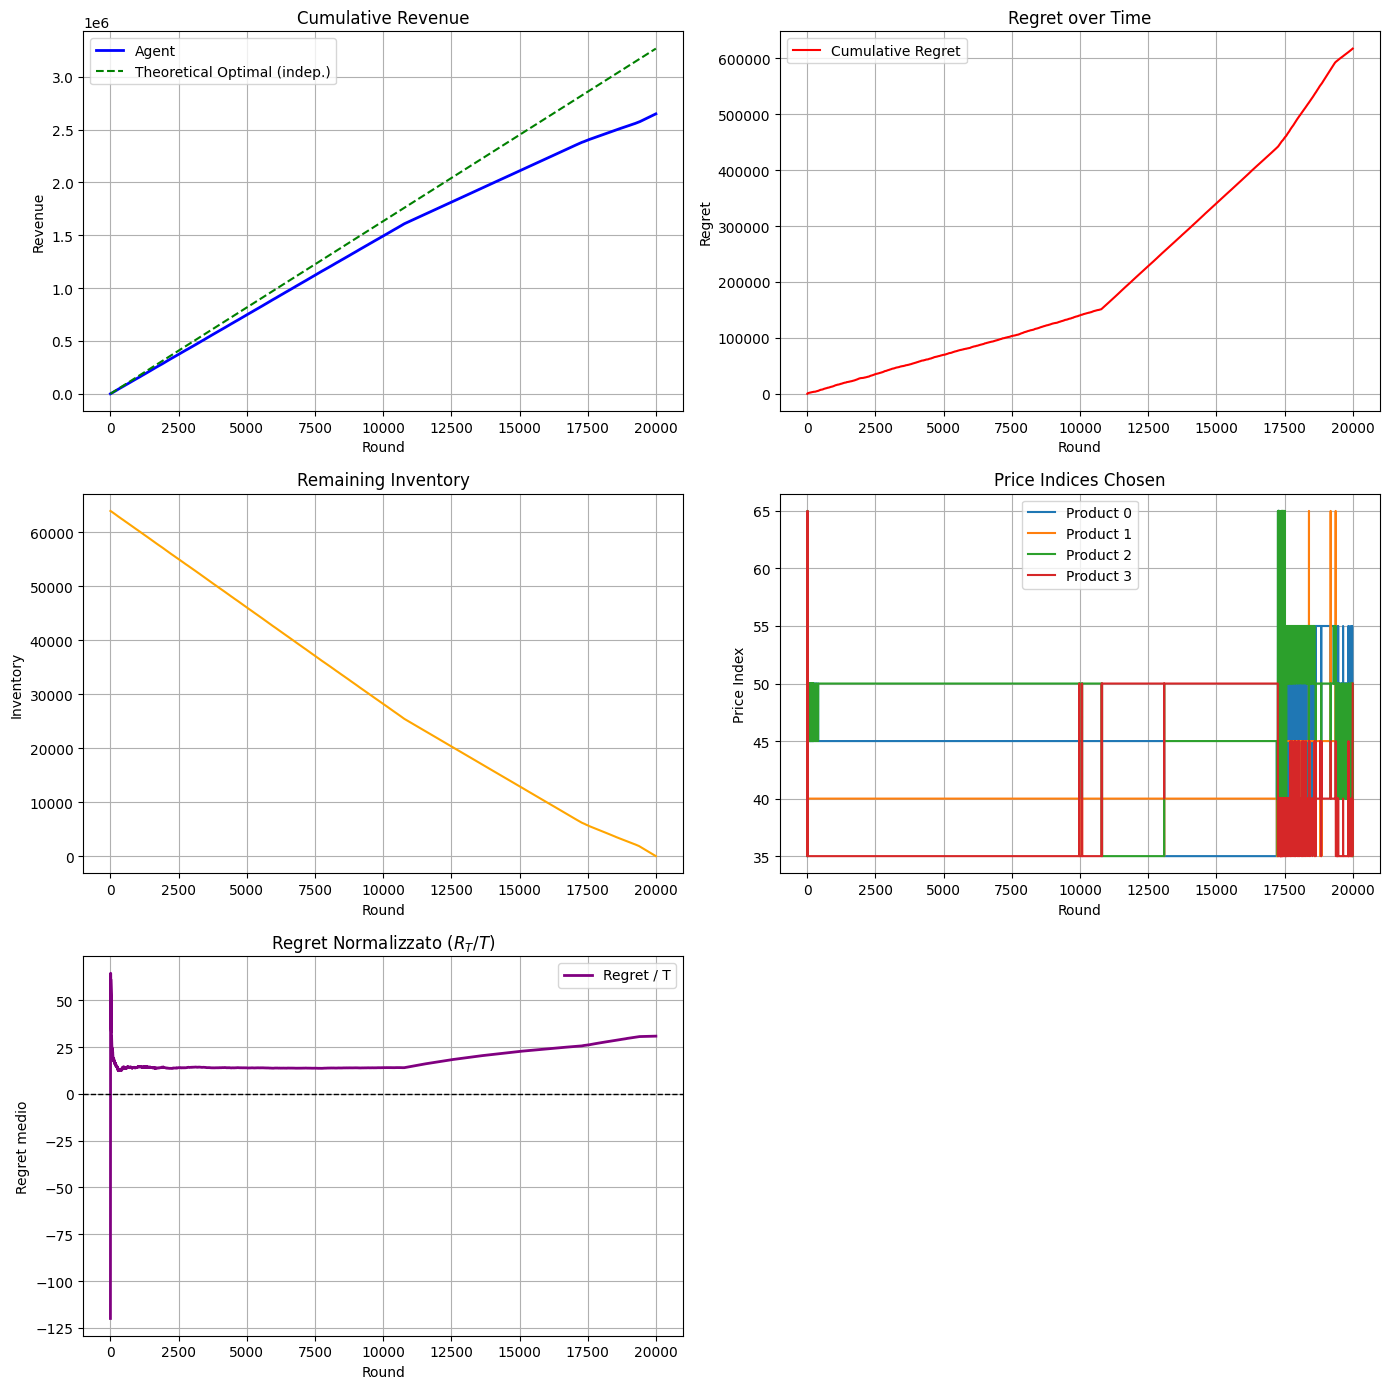

Final regret: 617585.74
Average regret per round: 30.8793


In [217]:

#Run a complete simulation

# Simulation parameters
T = 20000
n_products = 4
inventory = T*n_products*0.8 # Production capacity constraint
epsilon = T**(-1/3)  # Epsilon for UCB exploration

num_prices=7 #num_prices=20 # Ensure reasonable range
prices= np.linspace(35, 65, num=num_prices)


# enviroment parameters
# Joint valuation distribution parameters
valuation_means = [45, 50, 55, 60]
valuation_cov = np.array([
    [5, 0.0, 0.0],  # Covariance matrix for correlated valuations
    [0.0, 5, 0.0],
    [0.0, 0.0, 5]
])


# Valuation means: numeri casuali nel range [35, 60]
valuation_means = np.random.uniform(35, 60, size=n_products)
# Valuation variances: numeri casuali nel range [5, 15]
variances = np.round(np.random.uniform(5, 7, size=n_products), 1)
# Covarianza diagonale: varianza solo sulla diagonale
valuation_cov = np.diag(variances)


env = MultiProductPricingEnvironment(valuation_means, valuation_cov, prices, T, seed=42)


# Agent parameters
agent_params = {
    
    'n_products': n_products, 
    'prices': prices,  # set of prices 
    'T': T,  # number of rounds
    'total_inventory': inventory,  # inventory constraint
    'confidence_bound': 0.5,  # UCB exploration parameter (reduced for better performance)  
    'seed': 42,  # Random seed for reproducibility
    'rho_penalty': 1.0  

}
agent = CombinatorialUCBPricingAgent(**agent_params)


print(f"Number of price options: {len(agent_params['prices'])}")
print(f"UCB confidence bound: {agent_params['confidence_bound']}")
print(f'Inventory contrain: ',agent_params['total_inventory'])
print(f'Number of rounds:',agent_params['T'])

#run the simulation
agent, env, total_reward, total_purchases = run_simulation(T, env, agent, n_simulations=1, verbose=True)

valuation_stds = np.sqrt(np.diag(env.cov))
opt_prices, opt_revenue = compute_theoretical_optimum(env.prices, env.means, valuation_stds)

# Ensure that all price indices are within the correct range before plotting
for price_indices in agent.history['price_indices']:
    for idx in price_indices:
        if idx is not None and (idx < 0 or idx >= len(prices)):
            print(f"Warning: price index {idx} out of bounds for prices array of length {len(prices)}")



In [221]:
opt_prices

[np.float64(45.0), np.float64(40.0), np.float64(45.0), np.float64(40.0)]

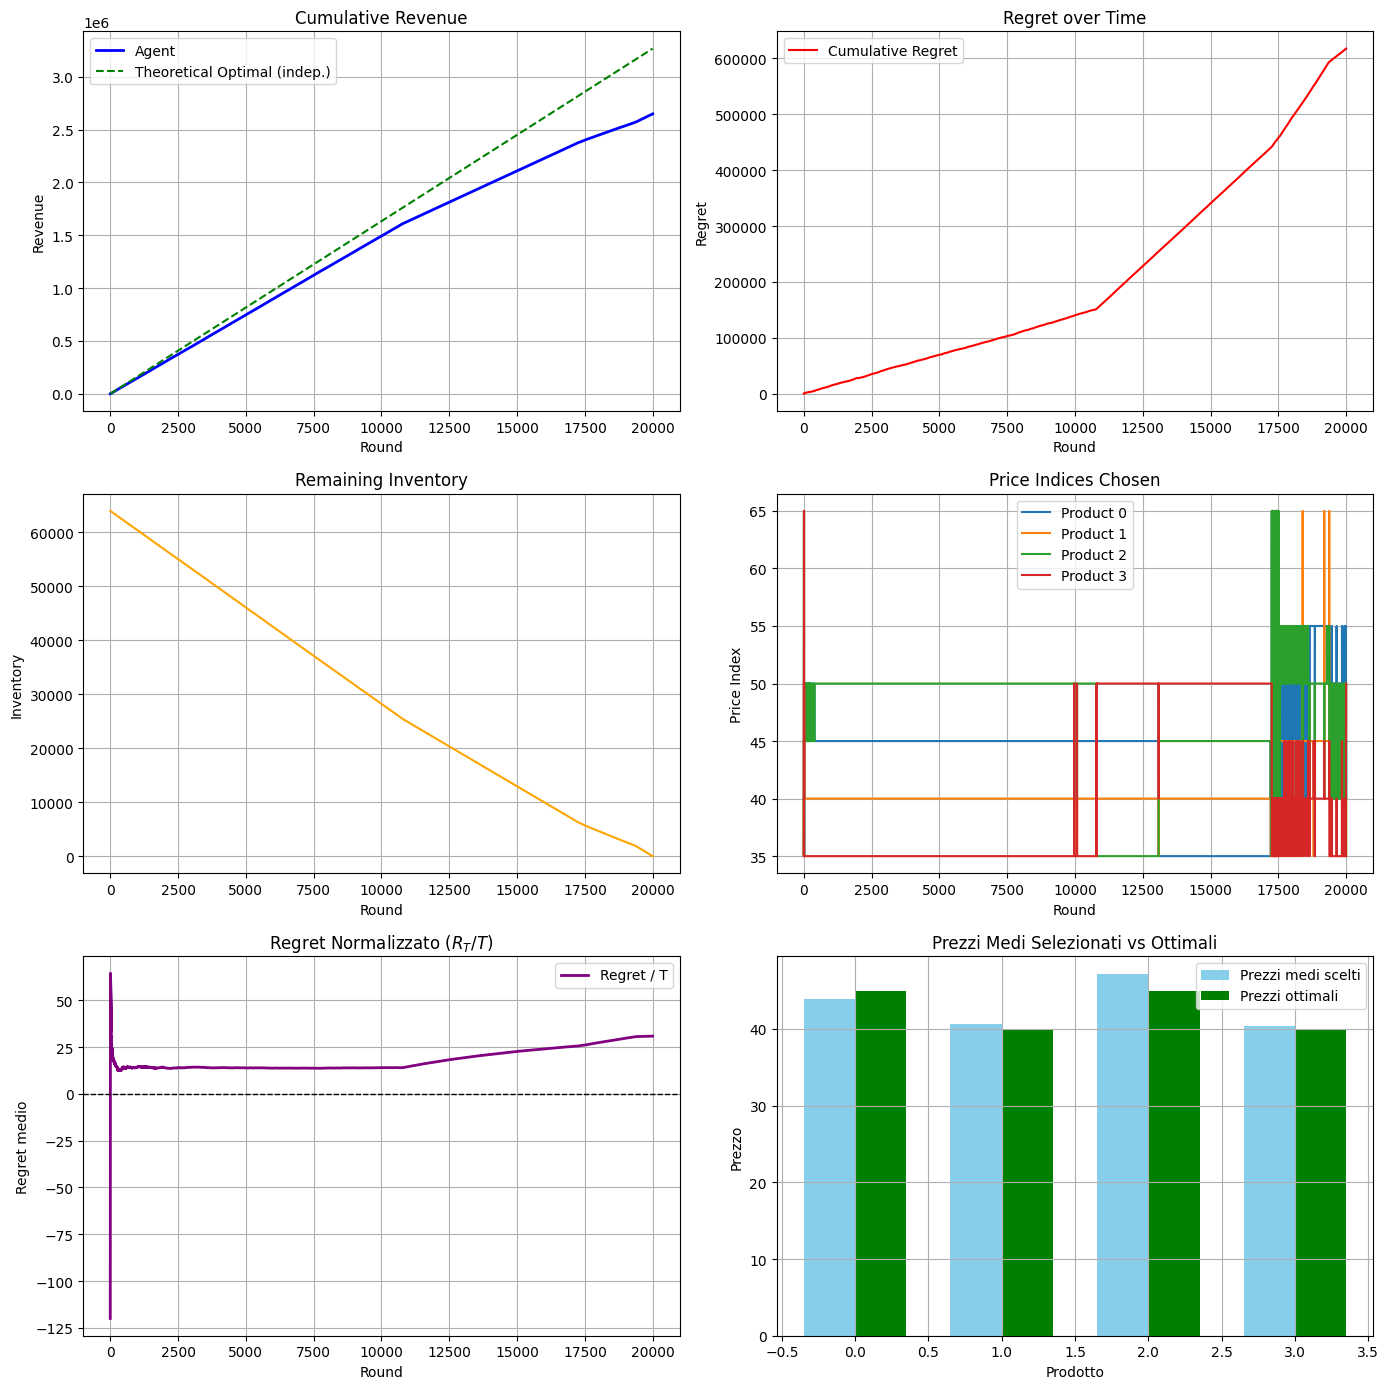

Final regret: 617585.74
Average regret per round: 30.8793


In [233]:
plot_results_ucb_multiproduct(agent, env, opt_revenue, opt_prices)


